In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
google_flowers = True
class_name_file = './data/class_indices.json'
train_data_path = "/media/stree/localssd/DL_data/flower_data2/train"
val_data_path = "/media/stree/localssd/DL_data/flower_data2/val"
test_data_path = "/media/stree/localssd/DL_data/flower_data2/val/"

if not google_flowers:
    class_name_file = './data/flowers_17_cat_to_name.json'
    train_data_path = "/media/stree/localssd/DL_data/flower_17/train"
    val_data_path = "/media/stree/localssd/DL_data/flower_17/val"
    test_data_path = "/media/stree/localssd/DL_data/flower_17/test/"
    
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open(class_name_file, 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes(train_data_path)
print(classes)
print(c_2_idx)
print()
cls_2_name = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    print('k: ', k, ' cls: ', cls)
    if google_flowers:
        cls_2_name[str(cls)] = cat_to_name[str(cls)]
    else:
        cls_2_name[int(cls)] = cat_to_name[str(k)]
print(cls_2_name)

{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
dandelion
tulips

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

k:  daisy  cls:  0
k:  dandelion  cls:  1
k:  roses  cls:  2
k:  sunflowers  cls:  3
k:  tulips  cls:  4
{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}


In [3]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
    
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=data_transform['train'])

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=data_transform['val'])

batch_size=16

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                               num_workers=nw)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

device = torch.device("cpu")
use_gpu = False
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
    use_gpu = True
        
print(device)
print(('load data ---> done!'))

Using 4 dataloader workers every process
cuda:0
load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[0 1 2 3 4]
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([3, 1, 3, 4, 3, 0, 4, 4, 3, 4, 1, 2, 2, 1, 1, 2])


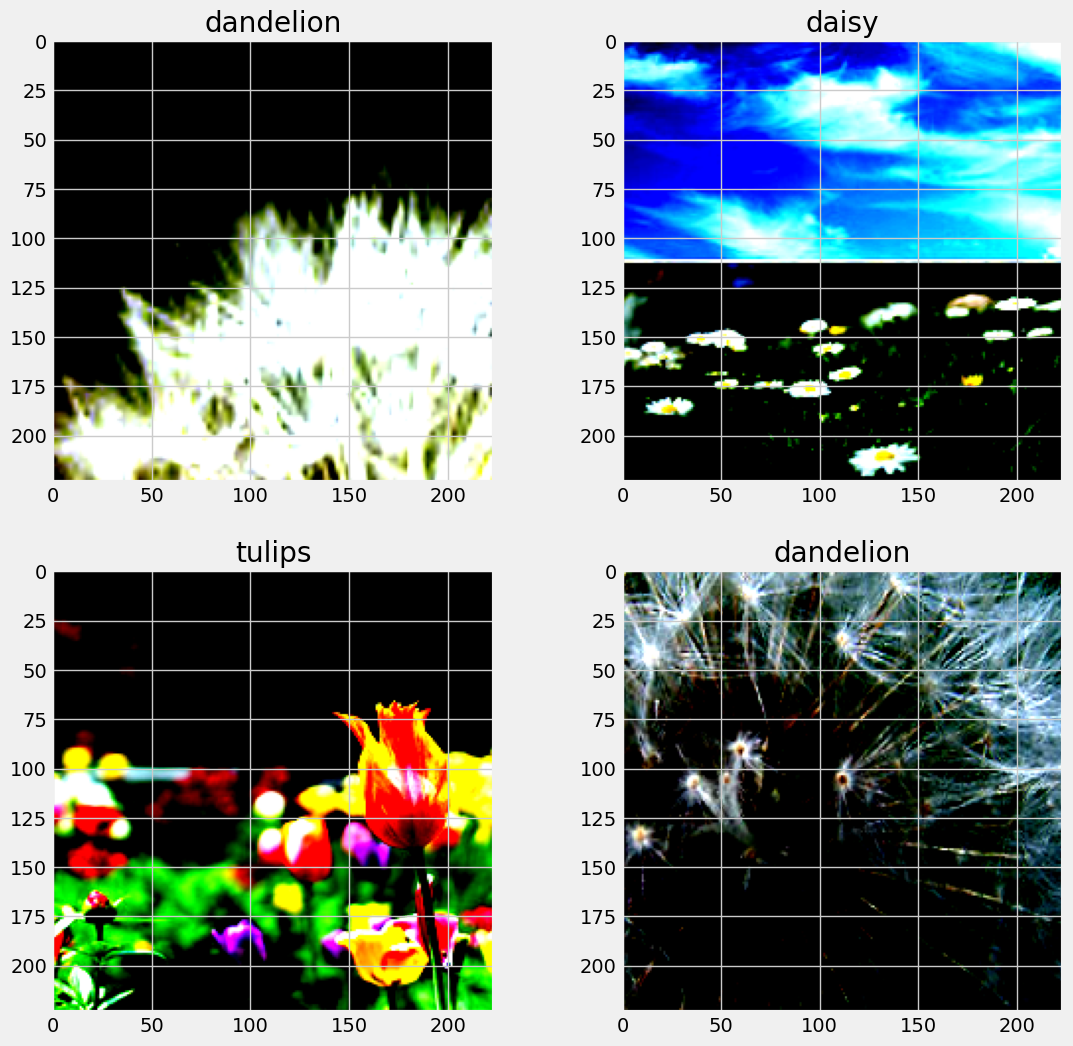

In [5]:
it = iter(train_data_loader)

dt,target = it.__next__()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
if google_flowers:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[str(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[str(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[str(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[str(target[13].numpy())])
else:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[int(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[int(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[int(target[13].numpy())])
plt.show()

In [6]:
################################
# network ShuffleNet
################################

class ShuffleBlock(nn.Module):
    def __init__(self, groups):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)


class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_planes = out_planes//4
        g = 1 if in_planes==24 else groups
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = torch.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out


class ShuffleNet(nn.Module):
    def __init__(self, cfg=None, num_classes=10):
        super(ShuffleNet, self).__init__()
        out_planes = cfg['out_planes']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_planes = 24
        self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
        #self.linear = nn.Linear(out_planes[2], num_classes)
        self.linear = nn.Linear(out_planes[2]*3*3, num_classes)

    def _make_layer(self, out_planes, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_planes = self.in_planes if i == 0 else 0
            layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) # => torch.Size([32, 160, 3, 3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ShuffleNetG1(num_classes=num_classes):
    cfg = {
        'out_planes': [40,80,160],
        'num_blocks': [1,2,1],
        'groups': 1
    }
    return ShuffleNet(cfg=cfg, num_classes=num_classes)

def ShuffleNetG2(num_classes=num_classes):
    cfg = {
        'out_planes': [200,400,800],
        'num_blocks': [4,8,4],
        'groups': 2
    }
    return ShuffleNet(cfg=cfg, num_classes=num_classes)

def ShuffleNetG3(num_classes=num_classes):
    cfg = {
        'out_planes': [240,480,960],
        'num_blocks': [4,8,4],
        'groups': 3
    }
    return ShuffleNet(cfg=cfg, num_classes=num_classes)

net = ShuffleNetG1(num_classes=num_classes)
x = torch.randn(32,3,224,224)
y = net(x)
print(y.size())

torch.Size([32, 5])


In [7]:
model = ShuffleNetG1(num_classes=num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 5])


In [8]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        
        if use_gpu:
            #print(torch.cuda.memory_summary())
            torch.cuda.empty_cache()
            
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets) 
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
            valid_loss /= len(val_loader.dataset)

        print('Epoch: {:3d},  Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [9]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

### Training model

In [10]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=30, device=device)

Epoch:   1,  Training Loss: 1.3287, Validation Loss: 1.1124, accuracy = 0.53
Epoch:   2,  Training Loss: 1.1471, Validation Loss: 1.0222, accuracy = 0.63
Epoch:   3,  Training Loss: 1.0305, Validation Loss: 0.9261, accuracy = 0.65
Epoch:   4,  Training Loss: 1.0319, Validation Loss: 0.8526, accuracy = 0.68
Epoch:   5,  Training Loss: 0.9588, Validation Loss: 1.0035, accuracy = 0.64
Epoch:   6,  Training Loss: 0.9387, Validation Loss: 0.8369, accuracy = 0.71
Epoch:   7,  Training Loss: 0.9233, Validation Loss: 0.8071, accuracy = 0.71
Epoch:   8,  Training Loss: 0.9225, Validation Loss: 0.7909, accuracy = 0.70
Epoch:   9,  Training Loss: 0.8992, Validation Loss: 0.8506, accuracy = 0.70
Epoch:  10,  Training Loss: 0.8879, Validation Loss: 0.7351, accuracy = 0.73
Epoch:  11,  Training Loss: 0.8787, Validation Loss: 0.7461, accuracy = 0.74
Epoch:  12,  Training Loss: 0.8966, Validation Loss: 0.7870, accuracy = 0.73
Epoch:  13,  Training Loss: 0.8638, Validation Loss: 0.9086, accuracy = 0.72

### Test

In [11]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=data_transform['val'])

batch_size=16
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=nw)
loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets) 
        test_loss += loss.data.item() * inputs.size(0)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    test_loss /= len(test_loader.dataset)

print('Test Loss: {:.4f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.8044, accuracy = 0.70


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 3, 2, 0, 0, 3, 0, 1, 0, 0, 0, 0], device='cuda:0')
(3, 224, 224)
(3, 1, 1)


<Figure size 2500x3000 with 0 Axes>

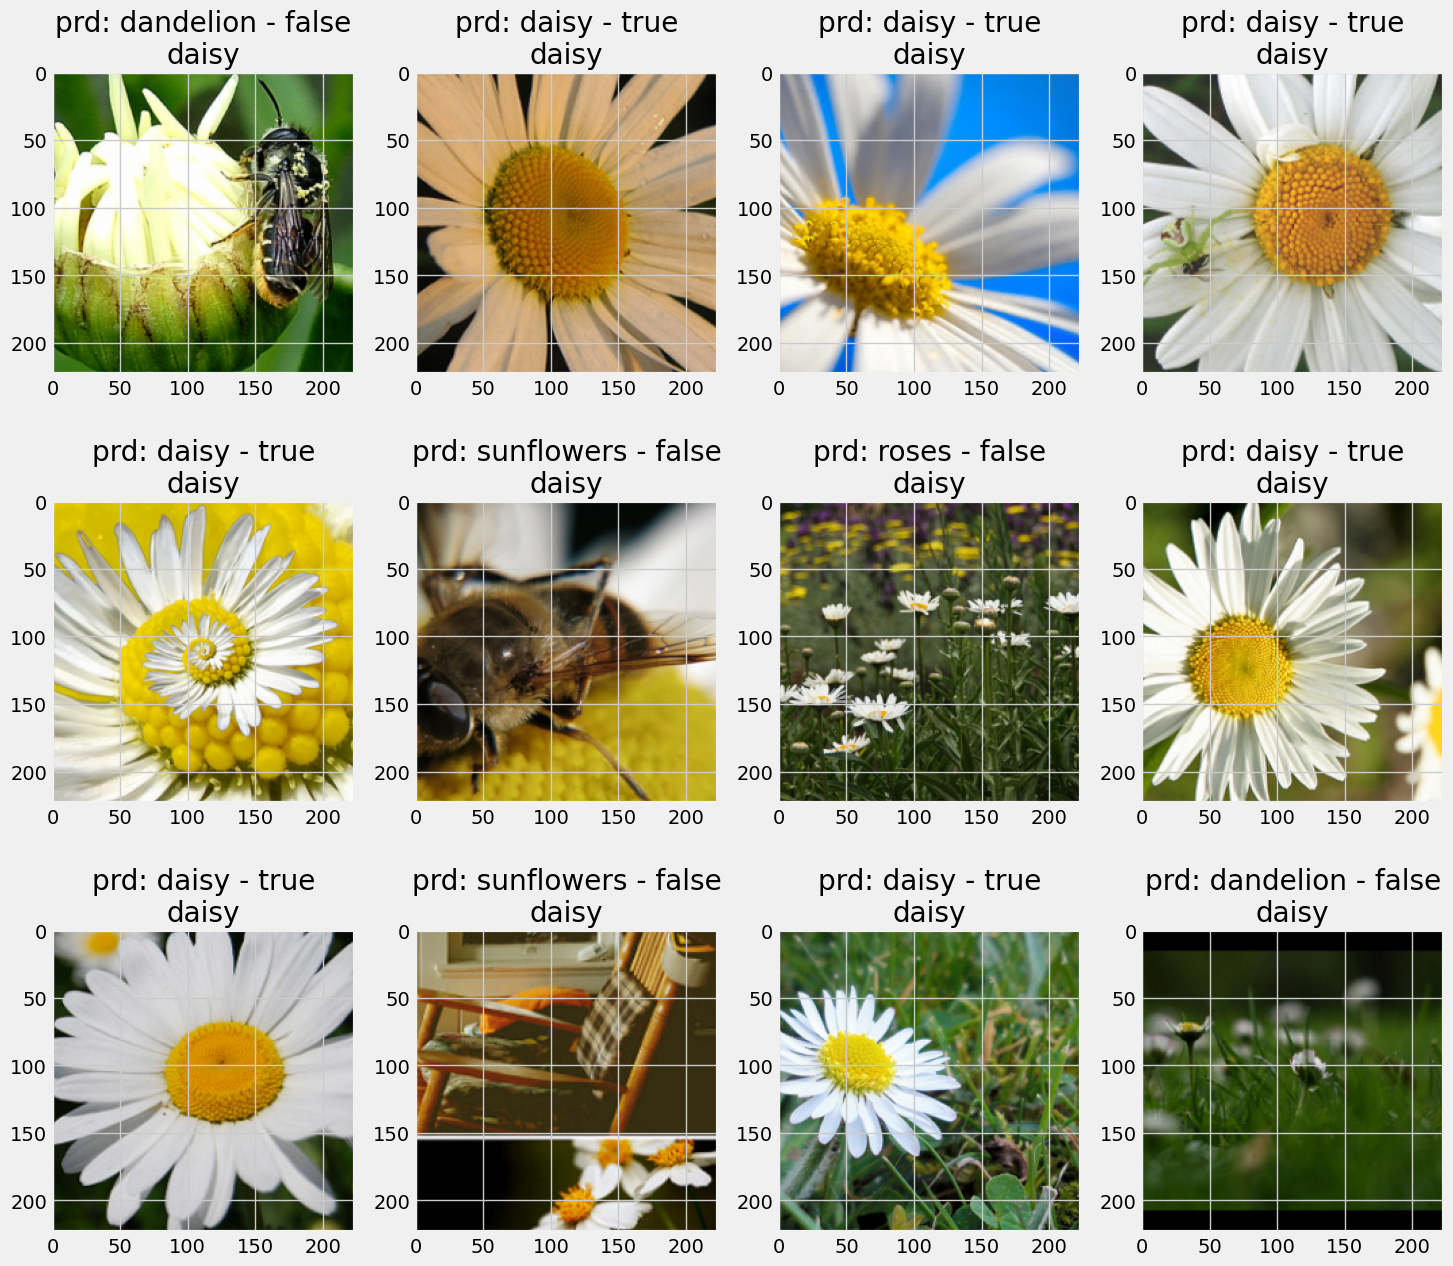

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  357803 KB |  490640 KB |   10956 GB |   10956 GB |
|       from large pool |  355424 KB |  487360 KB |   10908 GB |   10907 GB |
|       from small pool |    2379 KB |    4260 KB |      48 GB |      48 GB |
|---------------------------------------------------------------------------|
| Active memory         |  357803 KB |  490640 KB |   10956 GB |   10956 GB |
|       from large pool |  355424 KB |  487360 KB |   10908 GB |

In [12]:
it = iter(test_loader)
it.__next__()
dt, labs = it.__next__()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(dt[0].cpu().numpy().shape)
print(img_mean.cpu().numpy().shape)

plt.figure(figsize=(25,30))
row = 4
col = 3
if google_flowers:
    row = 3
    col = 4
    plt.figure(figsize=(16,15))
    
k = 0
for i in range(row):
    for j in range(col):
        if google_flowers:
            ax = plt.subplot2grid((3,4), (i,j))
        else:
            ax = plt.subplot2grid((4,5), (i,j)) 
        
        # -----------------------------------------------------------------------------------------------------------------
        # tensor denormalization
        # -----------------------------------------------------------------------------------------------------------------
        img_dt = torch.mul(dt[k], img_std) + img_mean
        img_dt = img_dt*255
        img_dt = img_dt.to(torch.uint8)
        
        if use_gpu:
            img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - false\n ' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        else:
            img_dt = img_dt.numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - true\n ' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()

if use_gpu:
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary())